# Load Python Modules

In [ ]:
import anndata
import scanpy as sc
import scvi
import scvelo as scv
import pandas as pd
from time import gmtime, strftime
import os
strftime("%Y-%m-%d %H:%M:%S", gmtime())

In [2]:
mainDir = ${working directory}

In [407]:
library_dict = ["library1",'library2','library3' ]

In [ ]:
library = library_dict[0]
print(library)

adata0 = sc.read_h5ad(mainDir + library + '/cellbender/' + library + '.Cellbender.h5ad')
adata0.var_names_make_unique()

# merge results of doubletFinder
doubletFinderMeta = pd.read_table(mainDir + library + "/DoubletFinder/" + library + ".DoubletFinder.metaData.txt",
                        sep = '\t')
adata0.obs = adata0.obs.join(doubletFinderMeta, lsuffix='_cellbender', rsuffix='_doubletFinder')
adata0.obs.index = library + ":" + adata0.obs.index
adata0 = adata0[adata0.obs["doubletFinder_result"]=="Singlet"]
del library_dict[0]
adata0

In [ ]:
for library in library_dict :
    print("library = "+library)
    
    adata1 = sc.read_h5ad(mainDir + library + '/cellbender/' + library + '.Cellbender.h5ad')
    adata1.var_names_make_unique()

    # merge results of doubletFinder
    doubletFinderMeta = pd.read_table(mainDir + library + "/DoubletFinder/" + library + ".DoubletFinder.metaData.txt",
                            sep = '\t')
    adata1.obs = adata1.obs.join(doubletFinderMeta, lsuffix='_cellbender', rsuffix='_doubletFinder')
    adata1.obs.index = library + ":" + adata1.obs.index
    adata1 = adata1[adata1.obs["doubletFinder_result"]=="Singlet"]

    # concatenate the adata
    adata0 = adata0.concatenate(adata1, index_unique=None)

In [ ]:
adata = adata0

In [ ]:
del adata0, adata1,doubletFinderMeta

In [ ]:
os.makedirs(mainDir + "scvi_integrated/" + strftime("%Y-%m-%d",gmtime()) + "/scanpy", exist_ok=True)

In [413]:
adata.write_h5ad(
          mainDir + "scvi_integrated/" + strftime("%Y-%m-%d",gmtime()) + "/scanpy/rawAnndata.h5ad")

In [414]:
adata.var_names = adata.var["features"]

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

In [415]:
adata

AnnData object with n_obs × n_vars = 76792 × 36601
    obs: 'orig.ident_cellbender', 'nCount_RNA_cellbender', 'nFeature_RNA_cellbender', 'orig.ident_doubletFinder', 'nCount_RNA_doubletFinder', 'nFeature_RNA_doubletFinder', 'percent.mt', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'doubletFinder_pANN', 'doubletFinder_result', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=False, groupby="orig.ident_doubletFinder")
# sc.pl.stacked_violin(adata,  ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby="batch",dendrogram=True)

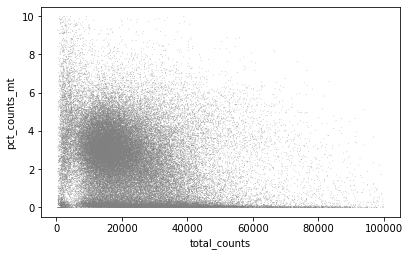

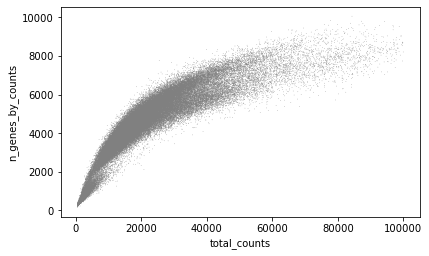

In [417]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', groups="orig.ident_doubletFinder")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata = adata[adata.obs.n_genes_by_counts > 100, 0:]
adata = adata[adata.obs.total_counts < 100000, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter=0.4, multi_panel=False, groupby="orig.ident_doubletFinder")
# sc.pl.stacked_violin(adata,  ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], groupby="batch",dendrogram=True)

In [ ]:
adata.obs.groupby("orig.ident_doubletFinder").count()["orig.ident_cellbender"]

In [420]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.raw = adata # freeze the state in '.raw'

In [421]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=10000,
    subset=True,
    layer="counts",
    flavor="seurat_v3", # for seurat_v3, it use dispersion-based methods
    batch_key="orig.ident_doubletFinder"
)

In [422]:
adata

AnnData object with n_obs × n_vars = 76792 × 10000
    obs: 'orig.ident_cellbender', 'nCount_RNA_cellbender', 'nFeature_RNA_cellbender', 'orig.ident_doubletFinder', 'nCount_RNA_doubletFinder', 'nFeature_RNA_doubletFinder', 'percent.mt', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'doubletFinder_pANN', 'doubletFinder_result', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'orig.ident_doubletFinder_colors', 'log1p', 'hvg'
    layers: 'counts'

In [423]:
import numpy as np

In [ ]:
adata.obs["log_nCount_RNA"] = np.log1p(adata.obs["nCount_RNA_doubletFinder"])

In [426]:
scvi.model.SCVI.setup_anndata(adata,
                              layer="counts",
                              categorical_covariate_keys= ["orig.ident_doubletFinder"],
                              continuous_covariate_keys = ["pct_counts_mt"])

In [427]:
vae = scvi.model.SCVI(adata, n_latent=50, n_layers=3, dropout_rate=0.1, dispersion="gene")

In [428]:
vae.train(use_gpu = True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 104/104: 100%|██████████| 104/104 [17:54<00:00, 10.33s/it, loss=4.83e+03, v_num=1]


In [429]:
vae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 3, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [430]:
vae.save(mainDir + "/scvi_integrated/" + strftime("%Y-%m-%d %H:%M:%S", gmtime()) + "/scviModel/" )

## Obtaining model output

In [431]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [432]:
adata.layers["scvi_normalized"] = vae.get_normalized_expression(
    library_size=10e4
)

# Interoperability with Scanpy

## Visualization with batch correction (scVI)

In [433]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI
                ")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.pl.umap(
    adata,
    color=["orig.ident_doubletFinder"],
    frameon=False,
    size = 10,
    sort_order = False,
    title = "Umap by Sample"
)

In [436]:
adata.obs["condition"] = adata.obs["orig.ident_doubletFinder"].str.slice(0,3)

In [ ]:
sc.pl.umap(
    adata,
    color=["condition"],
    frameon=False,
    size = 10,
    sort_order = False,
    title = "Umap by Condition"
)

In [ ]:
sc.pl.umap(adata, color="condition", size = 10 , groups = "CTR")

In [ ]:
sc.pl.umap(adata, color="condition", size = 10, groups = "SPR")

In [ ]:
sc.pl.umap(adata, color="condition", size = 10, groups = "GHR")

In [441]:
adata

AnnData object with n_obs × n_vars = 76792 × 10000
    obs: 'orig.ident_cellbender', 'nCount_RNA_cellbender', 'nFeature_RNA_cellbender', 'orig.ident_doubletFinder', 'nCount_RNA_doubletFinder', 'nFeature_RNA_doubletFinder', 'percent.mt', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'doubletFinder_pANN', 'doubletFinder_result', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'condition'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'orig.ident_doubletFinder_colors', 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'condition_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'count

## Clustering on the scVI latent space

In [442]:
res = 1.0

In [443]:
# neighbors were already computed using scVI
sc.tl.louvain(adata, key_added="louvain_scVI_" + str(res), resolution= res)

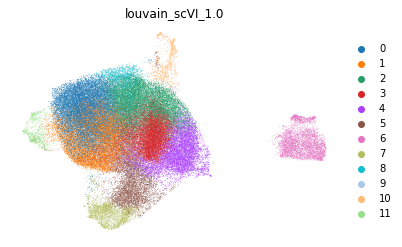

In [444]:
sc.pl.umap(
    adata,
    color=["louvain_scVI_"+ str(res)],
    frameon=False,
)

In [445]:
adata.write_h5ad(
          mainDir + "scvi_integrated/" + strftime("%Y-%m-%d",gmtime()) + "/scanpy/scvi_integrated.h5ad")


In [446]:
import math

import natsort
import pandas
import session_info


session_info.show()

# Differential expression

In [4]:
adata = sc.read_h5ad(mainDir + "scvi_integrated/" + date + "/scanpy/scvi_integrated.velocyto.cellcycle.3Dumap.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 73352 × 10000
    obs: 'orig.ident_cellbender', 'nCount_RNA_cellbender', 'nFeature_RNA_cellbender', 'orig.ident_doubletFinder', 'nCount_RNA_doubletFinder', 'nFeature_RNA_doubletFinder', 'percent.mt', 'percent.ribo', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'doubletFinder_pANN', 'doubletFinder_result', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'log_nCount_RNA', '_scvi_batch', '_scvi_labels', 'condition', 'louvain_scVI_1.0', 'sample', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'Cluster', 'S_score', 'G2M_score', 'phase', 'phate_tail'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'Cluster_col

In [ ]:
# vae.save(mainDir + "/scvi_integrated/" + strftime("%Y-%m-%d %H:%M:%S", gmtime()) + "/scviModel/" )
model = scvi.model.SCVI.load("/mnt/gmi-analysis01/_90.User_Data/juhyunk/project/schizophrenia/scRNA/singleCellAnalysis_byLibrary//scvi_integrated/2022-07-29/scanpy/", adata=adata, use_gpu=True)
# model = scvi.model.SCVI.load(mainDir + "/scvi_integrated/" + date + "/scviModel/", adata=adata, use_gpu=True)

In [7]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 50, n_layers: 3, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Trained

In [80]:
de_df = model.differential_expression(
    groupby="condition",
    group1="Case",
    group2="Control"
)


DE...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.63s/it]


In [81]:
de_df.head()

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
features,,,,,,,,,,,,,,,,,,,,,
PPP1R1B,0.9612,0.0388,3.209762,0.000002,5.685869e-07,0.0,0.25,1.714055,1.703503,1.021133,...,0.012064,0.000249,0.010762,0.000249,0.007509,0.000177,True,GHR vs CTR,GHR,CTR
SLC35F1,0.9602,0.0398,3.183274,0.000117,7.157495e-04,0.0,0.25,-4.015515,-4.225247,1.929328,...,1.744427,9.024969,0.216507,0.977618,0.930432,7.124952,True,GHR vs CTR,GHR,CTR
LERFS,0.9582,0.0418,3.132160,0.000002,1.597257e-05,0.0,0.25,-2.575450,-2.709818,1.390087,...,0.001877,0.153992,0.001838,0.129371,0.001666,0.136539,True,GHR vs CTR,GHR,CTR
NKD2,0.9490,0.0510,2.923583,0.000002,8.560236e-06,0.0,0.25,-1.715147,-2.163445,2.202389,...,0.003677,0.059140,0.003370,0.052375,0.003814,0.063991,True,GHR vs CTR,GHR,CTR
APOD,0.9440,0.0560,2.824774,0.000195,4.901363e-04,0.0,0.25,-0.931451,-1.317770,2.305860,...,2.646687,4.814673,0.697511,0.771151,2.071301,4.957573,True,GHR vs CTR,GHR,CTR


Text(0.5, 1.0, 'Schizophrenia Specific cluster DEG')

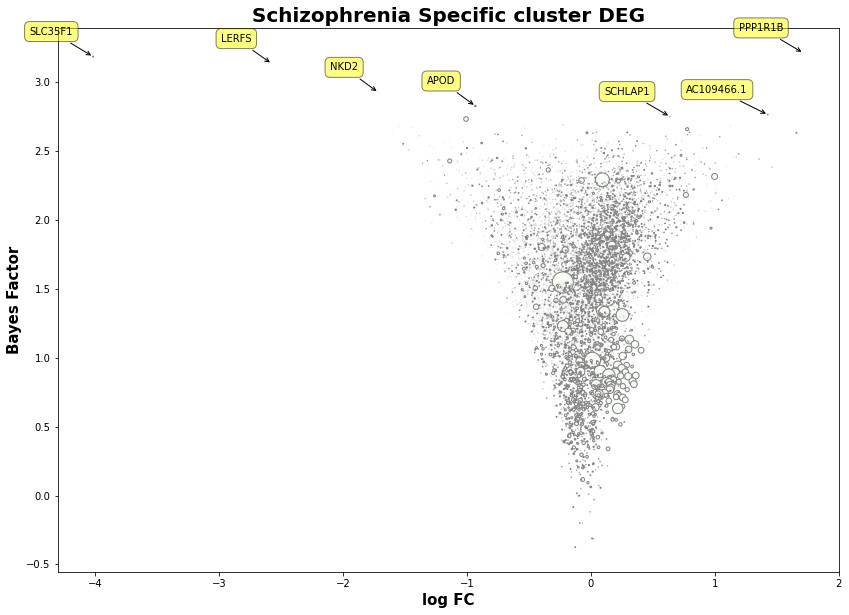

In [83]:
import matplotlib.pyplot as plt
import numpy as np

from adjustText import adjust_text
from faker import Faker
from palmerpenguins import load_penguins

################################
# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
GREY30 = "#4d4d4d"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
COLORS = ["#386cb0", "#fdb462", "#7fc97f" ] # A color for each species
################################

# Generate Faker instance and set seed or reproducibility
faker = Faker()
# Set seed for reproducibility of the random names
faker.seed_instance(11) 
#################################

fig, ax = plt.subplots(figsize= (14, 10))
ax.scatter(de_df['lfc_mean'],de_df['bayes_factor'], c=de_df['is_de_fdr_0.05'],
           cmap="Greens", edgecolor = 'gray', s=de_df['raw_normalized_mean1'])
topNum = 20


de_text = de_df.loc[de_df['is_de_fdr_0.05'] == True, ].sort_values(by=['raw_normalized_mean1'],ascending=False)
labels = de_text.index[0:topNum]
for label, x, y in zip(labels, de_text.lfc_mean[0:topNum], de_text.bayes_factor[0:topNum]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.ylabel('Bayes Factor', fontweight='bold', fontsize = 15)
plt.xlabel('log FC', fontweight='bold', fontsize = 15)
plt.title("Schizophrenia Specific cluster DEG", fontsize = 20,fontweight='bold')

In [307]:
de_df["normMax"] = de_df[["raw_normalized_mean1","raw_normalized_mean2"]].max(axis=1)

In [316]:
de_text.head(20).index

Index(['TIMP1', 'MALAT1', 'MGP', 'MT-CO2', 'MT-CO1', 'MT-CYB', 'MT-CO3',
       'MT-ATP6', 'MT-ND4', 'MT-ND3', 'TNC', 'MT-ND1', 'DCBLD2', 'MT-ND2',
       'AREG', 'MT-ND5', 'TRIO', 'ADAMTSL1', 'EXT1', 'MACF1'],
      dtype='object', name='features')

In [11]:
import matplotlib.pyplot as plt
import matplotlib

In [13]:
adata.obs["phate_tail_Cluster"] = adata.obs.phate_tail.astype(str) + adata.obs.Cluster.astype(str)

In [212]:
gene = "PPP1R1B"

In [ ]:
plt.rcParams["figure.figsize"] = [10,3]
sc.pl.violin(adata, keys=gene, groupby="cluter_cond", rotation=90, jitter=0, layer="scvi_normalized", use_raw=False, multi_panel = True)

In [ ]:
plt.rcParams["figure.figsize"] = [5,3]
sc.pl.violin(adata, keys=gene, groupby="condition", rotation=90, jitter=0.01, layer="scvi_normalized", use_raw=False)

In [ ]:
plt.rcParams["figure.figsize"] = [5,3]
sc.pl.violin(adata, keys=gene, groupby="sample", rotation=90, jitter=0.01, layer="scvi_normalized", use_raw=False)

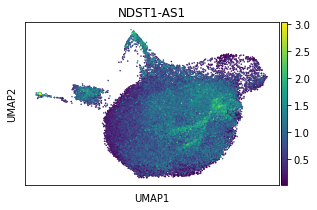

In [201]:
plt.rcParams["figure.figsize"] = [5,3]
sc.pl.umap(adata, color = gene, layer = "scvi_normalized", size = 10)

In [171]:
adata.obs["cluter_sample"] = adata.obs['Cluster'].astype(str) + "_" + adata.obs['sample'].astype(str)
adata.obs["cluter_cond"] = adata.obs['Cluster'].astype(str) + "_" + adata.obs['condition'].astype(str)

In [172]:
adata.obs.head()

,orig.ident_cellbender,nCount_RNA_cellbender,nFeature_RNA_cellbender,orig.ident_doubletFinder,nCount_RNA_doubletFinder,nFeature_RNA_doubletFinder,percent.mt,percent.ribo,nCount_SCT,nFeature_SCT,...,initial_size,Cluster,S_score,G2M_score,phase,phate_tail,_scvi_raw_norm_scaling,phate_tail_Cluster,cluter_sample,cluter_cond
CTR01:AAGACAAGTGGTAATA-1,0,69416.0,6642,CTR01,69416.0,6642.0,0.191598,23.774058,23651.0,3838.0,...,54592.0,9,-0.021989,-0.157879,G1,no,0.230739,no9,9_CTR01,9_CTR
CTR01:CTAGGTAAGATGGCAC-1,0,68781.0,6834,CTR01,68781.0,6834.0,0.053794,21.078496,23730.0,4110.0,...,54125.0,7,-0.012820,-0.145869,G1,no,0.231267,no7,7_CTR01,7_CTR
CTR01:ACGGGTCTCAGCCTCT-1,0,68161.0,7320,CTR01,68161.0,7320.0,0.608853,25.909244,23751.0,4596.0,...,49623.0,0,0.005373,-0.125073,S,no,0.247611,no0,0_CTR01,0_CTR
CTR01:CTCAACCCACGTATAC-1,0,67943.0,8743,CTR01,67943.0,8743.0,2.590407,11.893793,25272.0,6234.0,...,33617.0,6,-0.032042,-0.162007,G1,no,0.229774,no6,6_CTR01,6_CTR
CTR01:CAACAACTCTCCCAAC-1,0,67667.0,6837,CTR01,67667.0,6837.0,0.016256,25.177708,23690.0,3970.0,...,51165.0,7,-0.023015,-0.168176,G1,no,0.226660,no7,7_CTR01,7_CTR


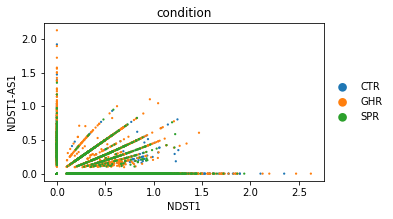

In [120]:
sc.pl.scatter(adata,x= "NDST1", y="NDST1-AS1", color="condition", size = 20)

In [325]:
 de_df.loc[(de_df['is_de_fdr_0.05'] == True) & (de_df['lfc_mean'] > 0 ), ].head(40).index

Index(['RBBP8NL', 'TIMP1', 'CST1', 'NLRP7', 'KISS1', 'CRIP2', 'CCL1',
       'AC005358.2', 'KCNN4', 'DNAI2', 'AC076966.2', 'AC005682.2', 'PLA2G2A',
       'IL23A', 'HES5', 'CYGB', 'AC147651.1', 'PMCH', 'TDRD15', 'CALY',
       'AC093912.1', 'PNLDC1', 'NPPC', 'C2CD4B', 'SERPINA3', 'COMP', 'CRLF1',
       'DCAF8L2', 'BTBD17', 'ELN', 'AC009154.1', 'CRYBB1', 'C12orf50', 'SSTR2',
       'GADD45G', 'OTP', 'TINAGL1', 'AC010649.1', 'SPINK1', 'PAGE5'],
      dtype='object', name='features')

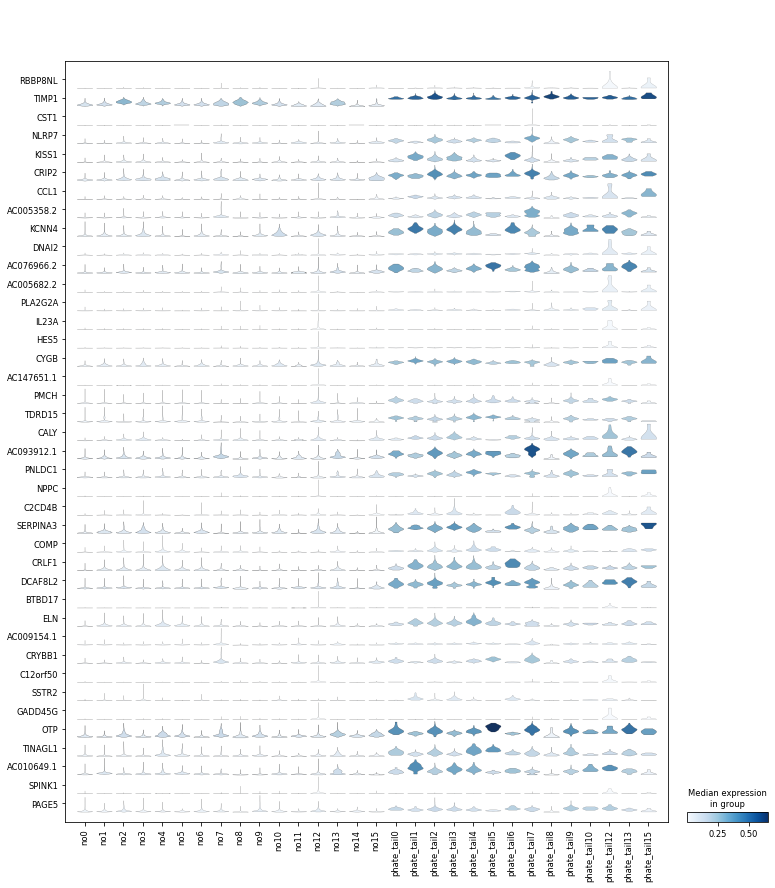

In [326]:
plt.rcParams["figure.figsize"] = [8,10]
sc.pl.stacked_violin(adata,
                     var_names= de_df.loc[(de_df['is_de_fdr_0.05'] == True) & (de_df['lfc_mean'] > 0 ), ].head(40).index,
                     groupby="phate_tail_Cluster", swap_axes=True,
                    layer = "scvi_normalized", 
                    standard_scale = "var")

In [ ]:
plt.rcParams["figure.figsize"] = [6,4]
sc.pl.umap(adata, color="condition", size = 10, groups="SPR")

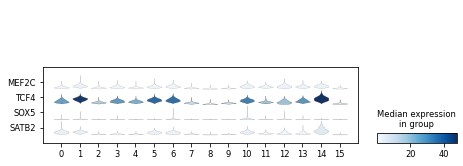

In [25]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.stacked_violin(adata,
                     var_names=["MEF2C","TCF4","SOX5","SATB2"],
                     groupby="Cluster", swap_axes=True,
                    layer = "scvi_normalized")

In [28]:
marker_genes_dict = {
    'Adipocytes': ["HOXC8",'HOXC9'],
    'qNSC': ['CLU','ID3'],
    'aNSC': ['RPL32','EGFR'],
    'NSC': ['NES'],
    'Neurogenesis': ['SOX2','CENPF','HES1','NES'],
    'Astrocyte': ['AQP4','GFAP','EDNRB','GJA1'],
    'Excitatory': ['CUX2','RORB','TLE4'], 
    'Inhibitory' : ['PVALB', 'SST', 'SV2C', 'RELN', ],
    'Glial': ['PLP1','VCAN','SLC1A2','CSF1R']}

In [359]:
marker_genes_dict = {
    'Adipocytes': ["HOXC8",'HOXC9'],
    'qNSC': ['CLU','ID3'],
    'aNSC': ['RPL32','EGFR'],
    'NSC': ['NES'],
    'Neurogenesis': ['SOX2','CENPF','HES1','NES'],
    'Astrocyte': ['AQP4','GFAP','EDNRB','GJA1']}

         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 0, 1, 2, etc.
var_group_labels: Adipocytes, qNSC, aNSC, etc.


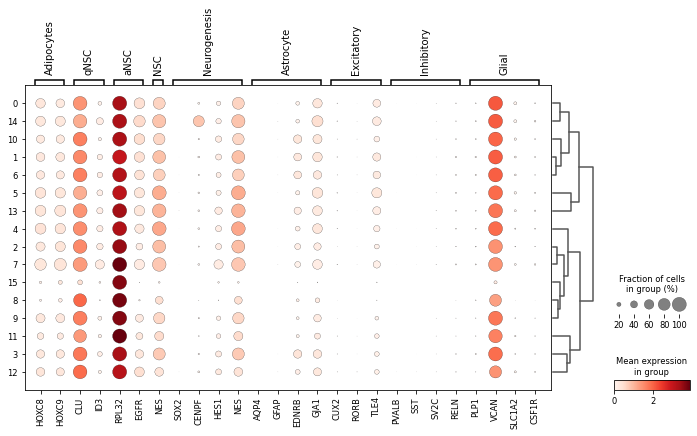

In [29]:
sc.pl.dotplot(adata, marker_genes_dict, groupby="Cluster", dendrogram=True)

In [ ]:
sc.pl.dotplot(adata, marker_genes_dict, groupby="cluter_cond",standard_scale = 'var', dendrogram=True)

In [ ]:
sc.pl.umap(adata, color = "Cluster", groups="13")

In [ ]:
plt.rcParams["figure.figsize"] = [3,4]
tmp = pd.crosstab(adata.obs['phate_tail'],adata.obs['sample'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))